In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
from transformers import T5Tokenizer,AutoTokenizer,BertTokenizer,AutoModel
import re
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data.csv')

In [ ]:
threshold = 0.4256
df['logic']=df['logic'].apply(lambda x: 1 if x > threshold else 0)

In [ ]:
df['logic'].value_counts()

,count
logic,
0,78308
1,55973


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [ ]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [ ]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
#save path=('/content/drive/MyDrive/filename)

In [ ]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)


In [ ]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [ ]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [ ]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [ ]:
y = scores

In [ ]:
vocab_size= len(tokenizer.get_vocab())
vocab_size

33

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the TCN block with residual connection
class TCNBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, dilation=1, dropout=0.1):
        super(TCNBlock, self).__init__()
        # Calculate padding to maintain sequence length
        padding = (kernel_size - 1) * dilation // 2
        self.conv = nn.Conv1d(input_dim, output_dim, kernel_size=kernel_size,
                               padding=padding, dilation=dilation)
        self.norm = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x  # Save the input for the residual connection
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x + residual  # Add the residual connection
        return x


class TCNEncoder(nn.Module):
    def __init__(self, vocab_size, model_dim, num_layers, max_len=39, kernel_size=3, dropout=0.1):
        super(TCNEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, model_dim)
        self.tcn_blocks = nn.ModuleList(
            [TCNBlock(model_dim, model_dim, kernel_size, dilation=2**i, dropout=dropout) for i in range(num_layers)]
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)  # Change shape to (batch_size, model_dim, sequence_length)
        for tcn_block in self.tcn_blocks:
            x = tcn_block(x)
        return x.transpose(1, 2)  # Change shape back to (batch_size, sequence_length, model_dim)


class CrossInteractionLayer(nn.Module):
    def __init__(self, model_dim, dropout=0.1):
        super(CrossInteractionLayer, self).__init__()
        self.conv = nn.Conv1d(model_dim * 2, model_dim, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm1d(model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, pep_refined, mhc_refined):
        combined = torch.cat((pep_refined, mhc_refined), dim=-1)
        combined = combined.transpose(1, 2)
        x = self.conv(combined)
        x = self.norm(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x.transpose(1, 2)



In [ ]:

class TCNModel(nn.Module):
    def __init__(self, model_dim, num_layers, dropout=0.1, vocab_size=33, num_classes=2):
        super(TCNModel, self).__init__()
        self.encoder_pep = TCNEncoder(vocab_size, model_dim, num_layers, dropout=dropout)
        self.encoder_mhc = TCNEncoder(vocab_size, model_dim, num_layers, dropout=dropout)
        self.cross_interaction = CrossInteractionLayer(model_dim, dropout)
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_classes)  # Changed to classification output

    def forward(self, pep_input, mhc_input):
        pep_refined = self.encoder_pep(pep_input)
        mhc_refined = self.encoder_mhc(mhc_input)
        cross_output = self.cross_interaction(pep_refined, mhc_refined)
        x = cross_output.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_labels, test_labels, train_mhc_input_ids, test_mhc_input_ids, train_mhc_attention_mask, test_mhc_attention_mask = train_test_split(
    pep_input_ids, pep_attention_mask, y, mhc_input_ids, mhc_attention_mask, test_size=0.2, random_state=42)

train_input_ids, val_input_ids, train_attention_mask, val_attention_mask, train_labels, val_labels, train_mhc_input_ids, val_mhc_input_ids, train_mhc_attention_mask, val_mhc_attention_mask = train_test_split(
    train_input_ids, train_attention_mask, train_labels, train_mhc_input_ids, train_mhc_attention_mask, test_size=0.2, random_state=42)

train_data = TensorDataset(train_input_ids, train_attention_mask, train_mhc_input_ids, train_mhc_attention_mask, train_labels)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = TensorDataset(val_input_ids, val_attention_mask, val_mhc_input_ids, val_mhc_attention_mask, val_labels)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

test_data = TensorDataset(test_input_ids, test_attention_mask, test_mhc_input_ids, test_mhc_attention_mask, test_labels)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)




In [ ]:
torch.manual_seed(4201)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

def objective(trial):
    model_dim = trial.suggest_categorical("model_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_categorical("lr", [1e-3, 1e-4])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    model = TCNModel(model_dim=model_dim, num_layers=num_layers, dropout=dropout, vocab_size=33, num_classes=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    num_epochs = 5
    best_auroc = 0

    print(f"Starting Trial {trial.number} with params: model_dim={model_dim}, num_layers={num_layers}, dropout={dropout:.4f}, lr={lr:.6f}, batch_size={batch_size}")

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
            labels_batch = labels_batch.float().to(device)
            optimizer.zero_grad()
            outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch in val_loader:
                pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
                labels_batch = labels_batch.float().to(device)
                outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(torch.sigmoid(outputs).cpu().numpy())

        auroc = roc_auc_score(y_true, y_pred)
        print(f"Epoch {epoch+1}/{num_epochs} - AUROC: {auroc:.4f}")

        if auroc > best_auroc:
            best_auroc = auroc

    print(f"Trial {trial.number} completed - Best AUROC: {best_auroc:.4f}\n")
    return best_auroc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-02-09 11:15:10,464] A new study created in memory with name: no-name-08ffba4d-5a05-4430-a6ee-92eeecfceca4


Starting Trial 0 with params: model_dim=128, num_layers=4, dropout=0.2164, lr=0.001000, batch_size=64
Epoch 1/5 - AUROC: 0.8279
Epoch 2/5 - AUROC: 0.8480
Epoch 3/5 - AUROC: 0.8589
Epoch 4/5 - AUROC: 0.8625


[I 2025-02-09 11:16:42,571] Trial 0 finished with value: 0.8686862231623165 and parameters: {'model_dim': 128, 'num_layers': 4, 'dropout': 0.21636014704275805, 'lr': 0.001, 'batch_size': 64}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8687
Trial 0 completed - Best AUROC: 0.8687

Starting Trial 1 with params: model_dim=128, num_layers=3, dropout=0.4081, lr=0.000100, batch_size=32
Epoch 1/5 - AUROC: 0.8072
Epoch 2/5 - AUROC: 0.8261
Epoch 3/5 - AUROC: 0.8304
Epoch 4/5 - AUROC: 0.8415


[I 2025-02-09 11:18:50,661] Trial 1 finished with value: 0.8493136265410122 and parameters: {'model_dim': 128, 'num_layers': 3, 'dropout': 0.40809752188021853, 'lr': 0.0001, 'batch_size': 32}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8493
Trial 1 completed - Best AUROC: 0.8493

Starting Trial 2 with params: model_dim=128, num_layers=4, dropout=0.4130, lr=0.000100, batch_size=64
Epoch 1/5 - AUROC: 0.8043
Epoch 2/5 - AUROC: 0.8235
Epoch 3/5 - AUROC: 0.8295
Epoch 4/5 - AUROC: 0.8411


[I 2025-02-09 11:20:08,519] Trial 2 finished with value: 0.8474882805496436 and parameters: {'model_dim': 128, 'num_layers': 4, 'dropout': 0.4129688826664214, 'lr': 0.0001, 'batch_size': 64}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8475
Trial 2 completed - Best AUROC: 0.8475

Starting Trial 3 with params: model_dim=64, num_layers=4, dropout=0.2096, lr=0.000100, batch_size=32
Epoch 1/5 - AUROC: 0.8118
Epoch 2/5 - AUROC: 0.8291
Epoch 3/5 - AUROC: 0.8382
Epoch 4/5 - AUROC: 0.8485


[I 2025-02-09 11:22:34,033] Trial 3 finished with value: 0.8530207540327798 and parameters: {'model_dim': 64, 'num_layers': 4, 'dropout': 0.2095573444040781, 'lr': 0.0001, 'batch_size': 32}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8530
Trial 3 completed - Best AUROC: 0.8530

Starting Trial 4 with params: model_dim=256, num_layers=4, dropout=0.4718, lr=0.000100, batch_size=16
Epoch 1/5 - AUROC: 0.8142
Epoch 2/5 - AUROC: 0.8293
Epoch 3/5 - AUROC: 0.8428
Epoch 4/5 - AUROC: 0.8517


[I 2025-02-09 11:27:18,499] Trial 4 finished with value: 0.8571183489867233 and parameters: {'model_dim': 256, 'num_layers': 4, 'dropout': 0.4718245691537142, 'lr': 0.0001, 'batch_size': 16}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8571
Trial 4 completed - Best AUROC: 0.8571

Starting Trial 5 with params: model_dim=64, num_layers=4, dropout=0.1454, lr=0.000100, batch_size=16
Epoch 1/5 - AUROC: 0.8164
Epoch 2/5 - AUROC: 0.8328
Epoch 3/5 - AUROC: 0.8466
Epoch 4/5 - AUROC: 0.8526


[I 2025-02-09 11:32:01,927] Trial 5 finished with value: 0.8563765533445452 and parameters: {'model_dim': 64, 'num_layers': 4, 'dropout': 0.14538412233710601, 'lr': 0.0001, 'batch_size': 16}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8564
Trial 5 completed - Best AUROC: 0.8564

Starting Trial 6 with params: model_dim=64, num_layers=4, dropout=0.2830, lr=0.000100, batch_size=64
Epoch 1/5 - AUROC: 0.7941
Epoch 2/5 - AUROC: 0.8147
Epoch 3/5 - AUROC: 0.8249
Epoch 4/5 - AUROC: 0.8335


[I 2025-02-09 11:33:19,247] Trial 6 finished with value: 0.8389371356639491 and parameters: {'model_dim': 64, 'num_layers': 4, 'dropout': 0.28295292944106337, 'lr': 0.0001, 'batch_size': 64}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8389
Trial 6 completed - Best AUROC: 0.8389

Starting Trial 7 with params: model_dim=64, num_layers=4, dropout=0.3318, lr=0.000100, batch_size=64
Epoch 1/5 - AUROC: 0.7902
Epoch 2/5 - AUROC: 0.8132
Epoch 3/5 - AUROC: 0.8246
Epoch 4/5 - AUROC: 0.8295


[I 2025-02-09 11:34:37,731] Trial 7 finished with value: 0.8353272394712418 and parameters: {'model_dim': 64, 'num_layers': 4, 'dropout': 0.33176335797236006, 'lr': 0.0001, 'batch_size': 64}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8353
Trial 7 completed - Best AUROC: 0.8353

Starting Trial 8 with params: model_dim=128, num_layers=3, dropout=0.4016, lr=0.000100, batch_size=64
Epoch 1/5 - AUROC: 0.8045
Epoch 2/5 - AUROC: 0.8209
Epoch 3/5 - AUROC: 0.8303
Epoch 4/5 - AUROC: 0.8374


[I 2025-02-09 11:35:46,959] Trial 8 finished with value: 0.8445418214654219 and parameters: {'model_dim': 128, 'num_layers': 3, 'dropout': 0.4016229703467452, 'lr': 0.0001, 'batch_size': 64}. Best is trial 0 with value: 0.8686862231623165.


Epoch 5/5 - AUROC: 0.8445
Trial 8 completed - Best AUROC: 0.8445

Starting Trial 9 with params: model_dim=256, num_layers=4, dropout=0.3236, lr=0.001000, batch_size=32
Epoch 1/5 - AUROC: 0.8281
Epoch 2/5 - AUROC: 0.8479
Epoch 3/5 - AUROC: 0.8583
Epoch 4/5 - AUROC: 0.8629


[I 2025-02-09 11:38:21,209] Trial 9 finished with value: 0.8706710394513681 and parameters: {'model_dim': 256, 'num_layers': 4, 'dropout': 0.3235936232131089, 'lr': 0.001, 'batch_size': 32}. Best is trial 9 with value: 0.8706710394513681.


Epoch 5/5 - AUROC: 0.8707
Trial 9 completed - Best AUROC: 0.8707

Best Hyperparameters: {'model_dim': 256, 'num_layers': 4, 'dropout': 0.3235936232131089, 'lr': 0.001, 'batch_size': 32}


Starting Training...
Epoch 1/50 - Train Loss: 0.5532 - Val Loss: 0.5265 - AUROC: 0.8048 - PR AUC: 0.7642
New best model saved with Val Loss: 0.5265
Epoch 2/50 - Train Loss: 0.5127 - Val Loss: 0.5010 - AUROC: 0.8258 - PR AUC: 0.7880
New best model saved with Val Loss: 0.5010
Epoch 3/50 - Train Loss: 0.4900 - Val Loss: 0.5034 - AUROC: 0.8344 - PR AUC: 0.7995
Epoch 4/50 - Train Loss: 0.4749 - Val Loss: 0.4860 - AUROC: 0.8474 - PR AUC: 0.8129
New best model saved with Val Loss: 0.4860
Epoch 5/50 - Train Loss: 0.4608 - Val Loss: 0.4763 - AUROC: 0.8526 - PR AUC: 0.8203
New best model saved with Val Loss: 0.4763
Epoch 6/50 - Train Loss: 0.4506 - Val Loss: 0.4700 - AUROC: 0.8561 - PR AUC: 0.8252
New best model saved with Val Loss: 0.4700
Epoch 7/50 - Train Loss: 0.4402 - Val Loss: 0.4597 - AUROC: 0.8603 - PR AUC: 0.8302
New best model saved with Val Loss: 0.4597
Epoch 8/50 - Train Loss: 0.4325 - Val Loss: 0.4607 - AUROC: 0.8644 - PR AUC: 0.8345
Epoch 9/50 - Train Loss: 0.4247 - Val Loss: 0.451

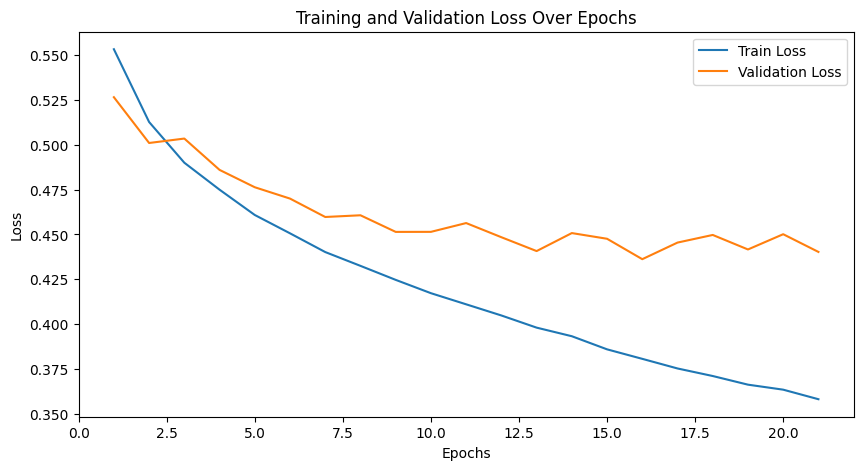

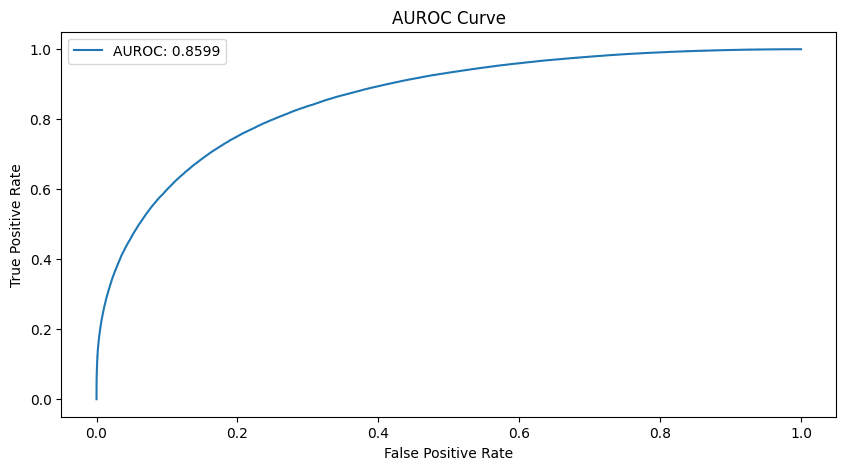

Training Complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from torch.utils.data import DataLoader

# Initialize best model path
best_model_path = "best_model.pth"

def train_model(model, train_data, val_data, device, best_model_path, patience=5, num_epochs=50):
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    early_stop_counter = 0

    all_y_true, all_y_pred = [], []

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
            labels_batch = labels_batch.float().to(device)

            optimizer.zero_grad()
            outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation step
        model.eval()
        total_val_loss = 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in val_loader:
                pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
                labels_batch = labels_batch.float().to(device)
                outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(torch.sigmoid(outputs).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Compute AUROC for this epoch
        auroc = roc_auc_score(y_true, y_pred)

        # Compute Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - AUROC: {auroc:.4f} - PR AUC: {pr_auc:.4f}")

        # Early stopping & model checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with Val Loss: {avg_val_loss:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Compute the final AUROC based on accumulated true and predicted values
    final_auroc = roc_auc_score(all_y_true, all_y_pred)
    print(f"Final AUROC (across all epochs): {final_auroc:.4f}")

    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1,len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.show()

    # Plot AUROC curve
    fpr, tpr, _ = roc_curve(all_y_true, all_y_pred)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'AUROC: {final_auroc:.4f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC Curve")
    plt.legend()
    plt.show()

    print("Training Complete.")

# Load best hyperparameters and train the model
model = TCNModel(model_dim=256, num_layers=4, dropout=0.3235, vocab_size=33, num_classes=1).to(device)
train_model(model, train_data, val_data, device, best_model_path)


<ipython-input-64-6dff93a0dac7>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(best_model_path, map_location=device)


Test AUROC: 0.8810
Test PR AUC: 0.8501
Test Precision: 0.7668
Test Recall: 0.7523
Test F1 Score: 0.7595
Test Accuracy: 0.7999
Confusion Matrix:
[[13000  2580]
 [ 2793  8484]]


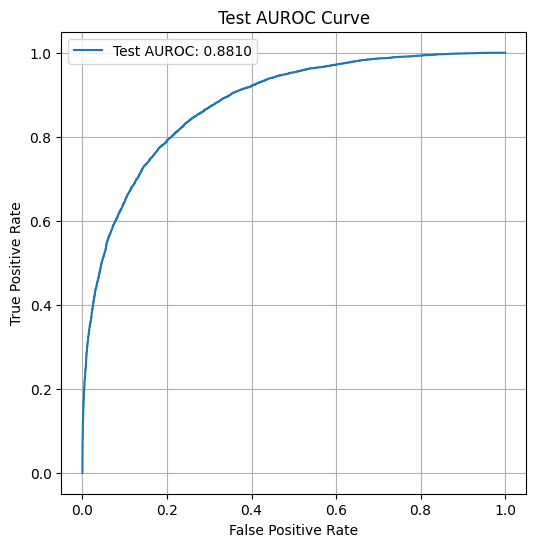

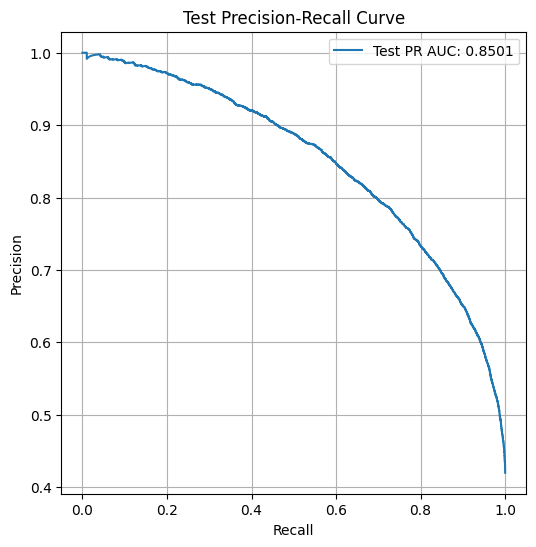

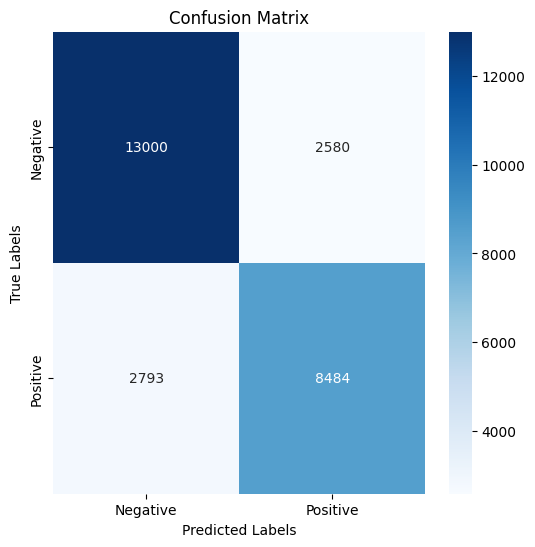

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from torch.utils.data import DataLoader


best_model_path = "/content/best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNModel(model_dim=256, num_layers=4, dropout=0.3235, vocab_size=33, num_classes=1).to(device)


model_state = torch.load(best_model_path, map_location=device)
if isinstance(model_state, dict):
    model.load_state_dict(model_state)
else:
    model = model_state

model.to(device)
model.eval()


def test_model(model, test_data, device):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
            labels_batch = labels_batch.float().to(device)
            outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()

            y_true.extend(labels_batch.cpu().numpy())
            y_pred.extend(torch.sigmoid(outputs).cpu().numpy())

    auroc = roc_auc_score(y_true, y_pred)
    p, r, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(r, p)

    y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred]

    cm = confusion_matrix(y_true, y_pred_binary)

    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    accuracy = accuracy_score(y_true, y_pred_binary)


    print(f"Test AUROC: {auroc:.4f}")
    print(f"Test PR AUC: {pr_auc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")


    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'Test AUROC: {auroc:.4f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test AUROC Curve")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 6))
    plt.plot(r, p, label=f'Test PR AUC: {pr_auc:.4f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Test Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()


    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return auroc, pr_auc, precision, recall, f1, accuracy

auroc, pr_auc, precision, recall, f1, accuracy = test_model(model, test_data, device)


Kfold

In [ ]:
train_input_ids, test_input_ids, train_attention_mask, test_attention_mask, train_labels, test_labels, train_mhc_input_ids, test_mhc_input_ids, train_mhc_attention_mask, test_mhc_attention_mask = train_test_split(
    pep_input_ids, pep_attention_mask, y, mhc_input_ids, mhc_attention_mask, test_size=0.2, random_state=42)

train_data = TensorDataset(train_input_ids, train_attention_mask, train_mhc_input_ids, train_mhc_attention_mask, train_labels)

test_data = TensorDataset(test_input_ids, test_attention_mask, test_mhc_input_ids, test_mhc_attention_mask, test_labels)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
best_models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"\nFold {fold+1}/5")
    train_subset = Subset(train_data, train_idx)
    val_subset = Subset(train_data, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = TCNModel(model_dim=256, num_layers=4, dropout=0.3235, vocab_size=33, num_classes=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float("inf")
    early_stop_counter = 0
    best_model_path = f"/content/drive/MyDrive/best_model_fold{fold+1}.pth"

    for epoch in range(50):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
            labels_batch = labels_batch.float().to(device)

            optimizer.zero_grad()
            outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in val_loader:
                pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
                labels_batch = labels_batch.float().to(device)
                outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
                loss = criterion(outputs, labels_batch)
                total_val_loss += loss.item()

                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(torch.sigmoid(outputs).cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)

        auroc = roc_auc_score(y_true, y_pred)
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)

        print(f"Epoch {epoch+1}/50 - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - AUROC: {auroc:.4f} - PR AUC: {pr_auc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved for Fold {fold+1} with Val Loss: {avg_val_loss:.4f}")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 5:
                print("Early stopping triggered")
                break

    fold_results.append({'fold': fold+1, 'best_val_loss': best_val_loss})
    best_models.append(best_model_path)

print("\nCross-validation complete. Best models saved for each fold.")



Fold 1/5
Epoch 1/50 - Train Loss: 0.5517 - Val Loss: 0.5289 - AUROC: 0.8070 - PR AUC: 0.7640
New best model saved for Fold 1 with Val Loss: 0.5289
Epoch 2/50 - Train Loss: 0.5100 - Val Loss: 0.5068 - AUROC: 0.8253 - PR AUC: 0.7905
New best model saved for Fold 1 with Val Loss: 0.5068
Epoch 3/50 - Train Loss: 0.4897 - Val Loss: 0.4995 - AUROC: 0.8332 - PR AUC: 0.7979
New best model saved for Fold 1 with Val Loss: 0.4995
Epoch 4/50 - Train Loss: 0.4758 - Val Loss: 0.4768 - AUROC: 0.8449 - PR AUC: 0.8116
New best model saved for Fold 1 with Val Loss: 0.4768
Epoch 5/50 - Train Loss: 0.4632 - Val Loss: 0.4779 - AUROC: 0.8468 - PR AUC: 0.8128
Epoch 6/50 - Train Loss: 0.4520 - Val Loss: 0.4628 - AUROC: 0.8558 - PR AUC: 0.8231
New best model saved for Fold 1 with Val Loss: 0.4628
Epoch 7/50 - Train Loss: 0.4431 - Val Loss: 0.4609 - AUROC: 0.8580 - PR AUC: 0.8255
New best model saved for Fold 1 with Val Loss: 0.4609
Epoch 8/50 - Train Loss: 0.4342 - Val Loss: 0.4559 - AUROC: 0.8605 - PR AUC: 0

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
import torch.nn.functional as F

ensemble_preds = []
all_y_true = []
test_loss = 0.0

criterion = torch.nn.BCEWithLogitsLoss()

for model_path in best_models:
    model = TCNModel(model_dim=256, num_layers=4, dropout=0.3235, vocab_size=33, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    fold_preds = []
    fold_losses = []  # Store batch losses

    with torch.no_grad():
        for batch in test_loader:
            pep_input_ids_batch, _, mhc_input_ids_batch, _, labels_batch = batch
            labels_batch = labels_batch.float().to(device)

            outputs = model(pep_input_ids_batch.to(device), mhc_input_ids_batch.to(device)).squeeze()
            loss = criterion(outputs, labels_batch)
            fold_losses.append(loss.item())

            fold_preds.append(torch.sigmoid(outputs).cpu().numpy())

            if model_path == best_models[0]:
                all_y_true.append(labels_batch.cpu().numpy())

    ensemble_preds.append(np.concatenate(fold_preds))


    test_loss += np.mean(fold_losses)


test_loss /= len(best_models)

all_y_true = np.concatenate(all_y_true)
final_preds = np.mean(ensemble_preds, axis=0)
final_preds_binary = (final_preds >= 0.4256).astype(int)

test_auroc = roc_auc_score(all_y_true, final_preds)
test_precision = precision_score(all_y_true, final_preds_binary)
test_recall = recall_score(all_y_true, final_preds_binary)
test_p, test_r, _ = precision_recall_curve(all_y_true, final_preds)
test_pr_auc = auc(test_r, test_p)
test_f1 = f1_score(all_y_true, final_preds_binary)

print(f"Test Loss: {test_loss:.4f} - Test AUROC: {test_auroc:.4f} - Test PR AUC: {test_pr_auc:.4f} - Test Precision: {test_precision:.4f} - Test Recall: {test_recall:.4f} - Test F1: {test_f1:.4f}")


Test Loss: 0.4286 - Test AUROC: 0.8933 - Test PR AUC: 0.8663 - Test Precision: 0.7495 - Test Recall: 0.8081 - Test F1: 0.7777


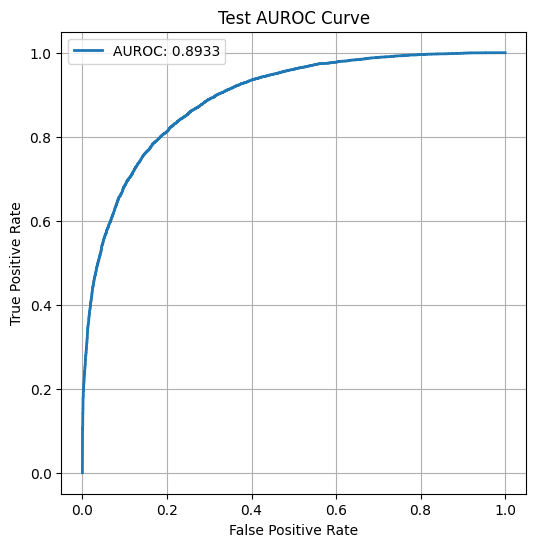

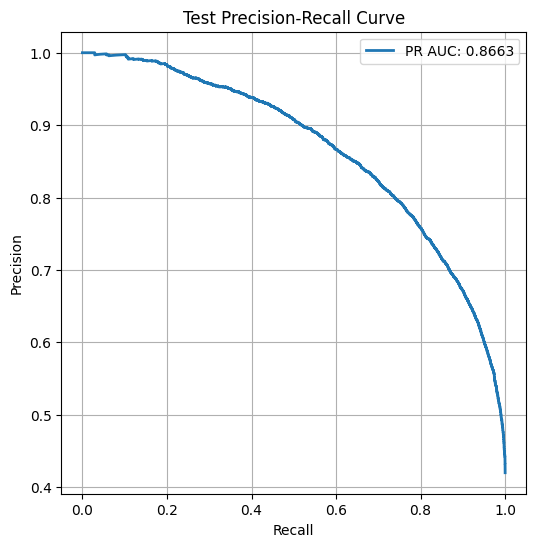

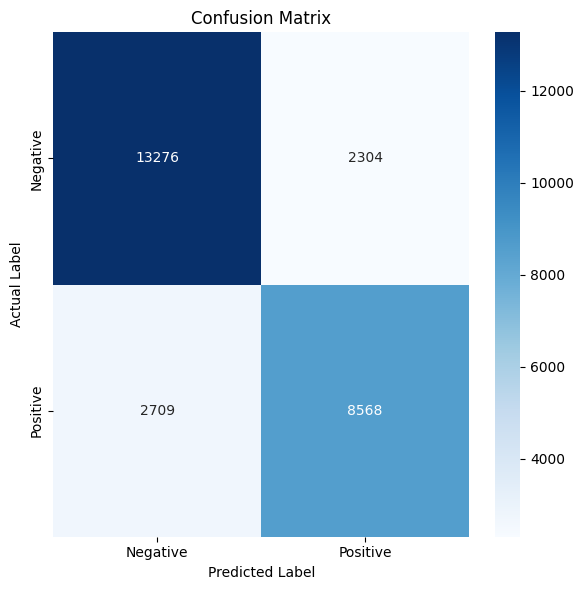

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# AUROC Curve
fpr, tpr, _ = roc_curve(all_y_true, final_preds)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUROC: {test_auroc:.4f}', linewidth=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUROC Curve")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(6, 6))
plt.plot(test_r, test_p, label=f'PR AUC: {test_pr_auc:.4f}', linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
threshold = 0.5
y_pred_labels = (final_preds >= threshold).astype(int)
conf_matrix = confusion_matrix(all_y_true, y_pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
